# CI for Budget to Rating
### This notebook will use IMDB and The Numbers data sets to derive an estimate for production budget to average rating

### Notes:
- IMDB has a column for rating
- The Numbers has a column for the production budget
- Combine both using the movie title as an index

In [1]:
### Import the nessesary libraries
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Getting the IMDB Ratings

In [2]:
### Connect to the IMDB Database
conn = sqlite3.connect('data/sqldata/im.db')

In [3]:
### Pull in IMDB rating table with the name of each film, both primary_title and original_title
q = """
SELECT 
    primary_title AS Primary_Title,
    original_title AS Original_Title,
    averagerating AS AVG_Rating,
    numvotes AS Num_Votes
FROM movie_ratings
JOIN movie_basics
    USING(movie_id)
;
"""
### Create Dataframe
df_rating = pd.read_sql(q, conn)
df_rating.head()

,Primary_Title,Original_Title,AVG_Rating,Num_Votes
0,Laiye Je Yaarian,Laiye Je Yaarian,8.3,31
1,Borderless,Borderless,8.9,559
2,Just Inès,Just Inès,6.4,20
3,The Legend of Hercules,The Legend of Hercules,4.2,50352
4,Até Onde?,Até Onde?,6.5,21


## Getting The Numbers production budgets

In [4]:
df_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
df_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
### Get the dataset into working condition
# Get rid of non-numerics in production_budget
df_budgets['budget_millions'] = df_budgets.production_budget.str.replace(',','')
df_budgets['budget_millions'] = df_budgets.budget_millions.str.replace('$','')
df_budgets['budget_millions'] = pd.to_numeric(df_budgets.budget_millions) / 1000000
df_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_millions
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",425.0
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.6
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.0
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.6
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",317.0


## Merging the two on movie title

In [6]:
### Merge on Primary Title
df_combine_pt = pd.merge(df_rating, 
                         df_budgets, 
                         how='inner', 
                         left_on = 'Primary_Title', 
                         right_on='movie')
df_combine_pt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2875 entries, 0 to 2874
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Primary_Title      2875 non-null   object 
 1   Original_Title     2875 non-null   object 
 2   AVG_Rating         2875 non-null   float64
 3   Num_Votes          2875 non-null   int64  
 4   id                 2875 non-null   int64  
 5   release_date       2875 non-null   object 
 6   movie              2875 non-null   object 
 7   production_budget  2875 non-null   object 
 8   domestic_gross     2875 non-null   object 
 9   worldwide_gross    2875 non-null   object 
 10  budget_millions    2875 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 269.5+ KB


In [7]:
### Merge on Original Title
df_combine_ot = pd.merge(df_rating, 
                         df_budgets, 
                         how='inner', 
                         left_on = 'Original_Title', 
                         right_on='movie')
df_combine_ot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2638 entries, 0 to 2637
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Primary_Title      2638 non-null   object 
 1   Original_Title     2638 non-null   object 
 2   AVG_Rating         2638 non-null   float64
 3   Num_Votes          2638 non-null   int64  
 4   id                 2638 non-null   int64  
 5   release_date       2638 non-null   object 
 6   movie              2638 non-null   object 
 7   production_budget  2638 non-null   object 
 8   domestic_gross     2638 non-null   object 
 9   worldwide_gross    2638 non-null   object 
 10  budget_millions    2638 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 247.3+ KB


In [8]:
### Checking to see the amount of unique values in both tables
print(len(df_combine_ot.movie.unique()),
      len(df_combine_pt.movie.unique()))
# Looks like we should keep it on pt and remove the duplicate movies

2066 2126


In [9]:
### Dropping the duplicate movie values
df_final = df_combine_pt.drop_duplicates(subset=['movie'],
                                         inplace=False)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2874
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Primary_Title      2126 non-null   object 
 1   Original_Title     2126 non-null   object 
 2   AVG_Rating         2126 non-null   float64
 3   Num_Votes          2126 non-null   int64  
 4   id                 2126 non-null   int64  
 5   release_date       2126 non-null   object 
 6   movie              2126 non-null   object 
 7   production_budget  2126 non-null   object 
 8   domestic_gross     2126 non-null   object 
 9   worldwide_gross    2126 non-null   object 
 10  budget_millions    2126 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 199.3+ KB


In [16]:
df_final.head()

,Primary_Title,Original_Title,AVG_Rating,Num_Votes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_millions
0,The Legend of Hercules,The Legend of Hercules,4.2,50352,42,"Jan 10, 2014",The Legend of Hercules,"$70,000,000","$18,848,538","$58,953,319",70.00
1,The Hammer,Hamill,7.0,1613,50,"Mar 21, 2008",The Hammer,"$850,000","$442,638","$442,638",0.85
3,Baggage Claim,Baggage Claim,5.1,8296,38,"Sep 27, 2013",Baggage Claim,"$8,500,000","$21,569,509","$22,885,836",8.50
4,Moneyball,Moneyball,7.6,326657,15,"Sep 23, 2011",Moneyball,"$50,000,000","$75,605,492","$111,300,835",50.00
5,Hereafter,Hereafter,6.5,87288,61,"Oct 15, 2010",Hereafter,"$50,000,000","$32,746,941","$108,660,270",50.00


## Looking into the statistics and Visualizations

In [10]:
import seaborn as sns

In [11]:
# df_final.plot(y='budget_millions',
#               by='AVG_Rating',
#               kind='hist',
#               bins=10)

x = df_final.groupby(['AVG_Rating'])['budget_millions'].median()
x

AVG_Rating
1.6    13.0
1.9    45.0
2.1    30.0
2.2     1.0
2.3    12.5
       ... 
8.7    11.5
8.8    28.0
9.0    20.0
9.1     9.2
9.2    48.0
Name: budget_millions, Length: 72, dtype: float64

<AxesSubplot:xlabel='AVG_Rating', ylabel='budget_millions'>

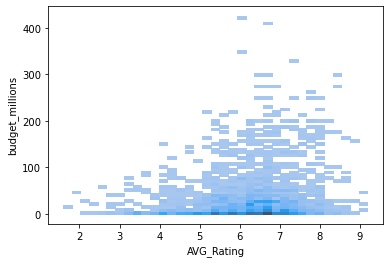

In [20]:
sns.histplot(x=df_final.AVG_Rating,
             y=df_final.budget_millions)

<AxesSubplot:xlabel='AVG_Rating', ylabel='Count'>

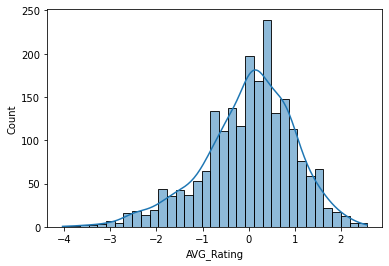

In [13]:
### Normalize the dataset on AVG_Rating using the mean
norm_avgrating = (df_final.AVG_Rating-df_final.AVG_Rating.mean())/df_final.AVG_Rating.std()
sns.histplot(norm_avgrating, kde=True)

## Try to establish a law of dimishing returns

<AxesSubplot:xlabel='AVG_Rating', ylabel='budget_millions'>

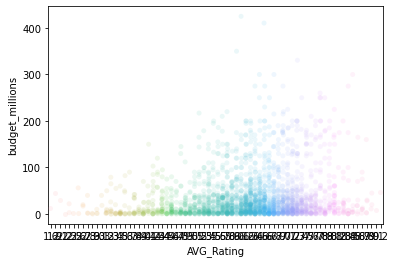

In [36]:
sns.stripplot(x=df_final.AVG_Rating,
              y=df_final.budget_millions,
              alpha=.1)

In [38]:
### Calculate the range of values we have
df_final['budget_millions'].describe()

count    2126.000000
mean       37.163874
std        51.129898
min         0.001400
25%         5.000000
50%        18.250000
75%        45.000000
max       425.000000
Name: budget_millions, dtype: float64

In [47]:
### Bin Calculation
# How many values are greater than 250?
df_final[df_final['budget_millions']>200].count()
#212 movies had budgets over 100M
#28 had budgets over 200M

budget_bins = [1, 2, 4, 8, 16, 32, 64, 108, 216]

In [84]:
def binning(x):
    if x > 216:
        return 216
    elif x > 108:
        return 108
    elif x > 64:
        return 64
    elif x > 32:
        return 32
    elif x > 16:
        return 16
    elif x > 8:
        return 8
    elif x > 4:
        return 4
    elif x > 2:
        return 2
    else:
        return 1
    
        

In [86]:
 x = [binning(x) for x in df_final['budget_millions']]

In [90]:
pd.options.mode.chained_assignment = None
df_final['budget_binning'] = x

In [91]:
df_final.head()

,Primary_Title,Original_Title,AVG_Rating,Num_Votes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_millions,budget_binning
0,The Legend of Hercules,The Legend of Hercules,4.2,50352,42,"Jan 10, 2014",The Legend of Hercules,"$70,000,000","$18,848,538","$58,953,319",70.00,64
1,The Hammer,Hamill,7.0,1613,50,"Mar 21, 2008",The Hammer,"$850,000","$442,638","$442,638",0.85,1
3,Baggage Claim,Baggage Claim,5.1,8296,38,"Sep 27, 2013",Baggage Claim,"$8,500,000","$21,569,509","$22,885,836",8.50,8
4,Moneyball,Moneyball,7.6,326657,15,"Sep 23, 2011",Moneyball,"$50,000,000","$75,605,492","$111,300,835",50.00,32
5,Hereafter,Hereafter,6.5,87288,61,"Oct 15, 2010",Hereafter,"$50,000,000","$32,746,941","$108,660,270",50.00,32


C:\Users\samumartin\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


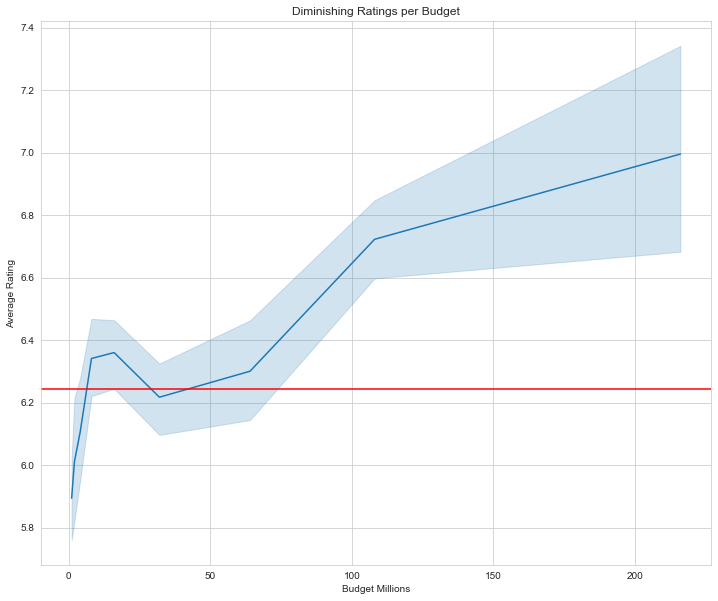

In [127]:
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.lineplot(df_final.budget_binning, df_final.AVG_Rating)
ax.set(xlabel='Budget Millions', ylabel='Average Rating', title='Diminishing Ratings per Budget')
ax.axhline(df_final.AVG_Rating.mean(), color='red')